In [61]:
import numpy as np
from hyperbolicity.tree_fitting_methods.neighbor_joining import NJ
from hyperbolicity.tree_fitting_methods.treerep import TreeRep
from hyperbolicity.tree_fitting_methods.hccfit import HccLinkage
from hyperbolicity.tree_fitting_methods.gromov import gromov_tree, buneman_extraction
from hyperbolicity.delta import compute_hyperbolicity
from hyperbolicity.tree_fitting_methods.tree_spanner import layering_approx_tree
from hyperbolicity.utils import construct_weighted_matrix, floyd_warshall
import matplotlib.pyplot as plt
import networkx as nx
from networkx.drawing.nx_pydot import graphviz_layout
import torch

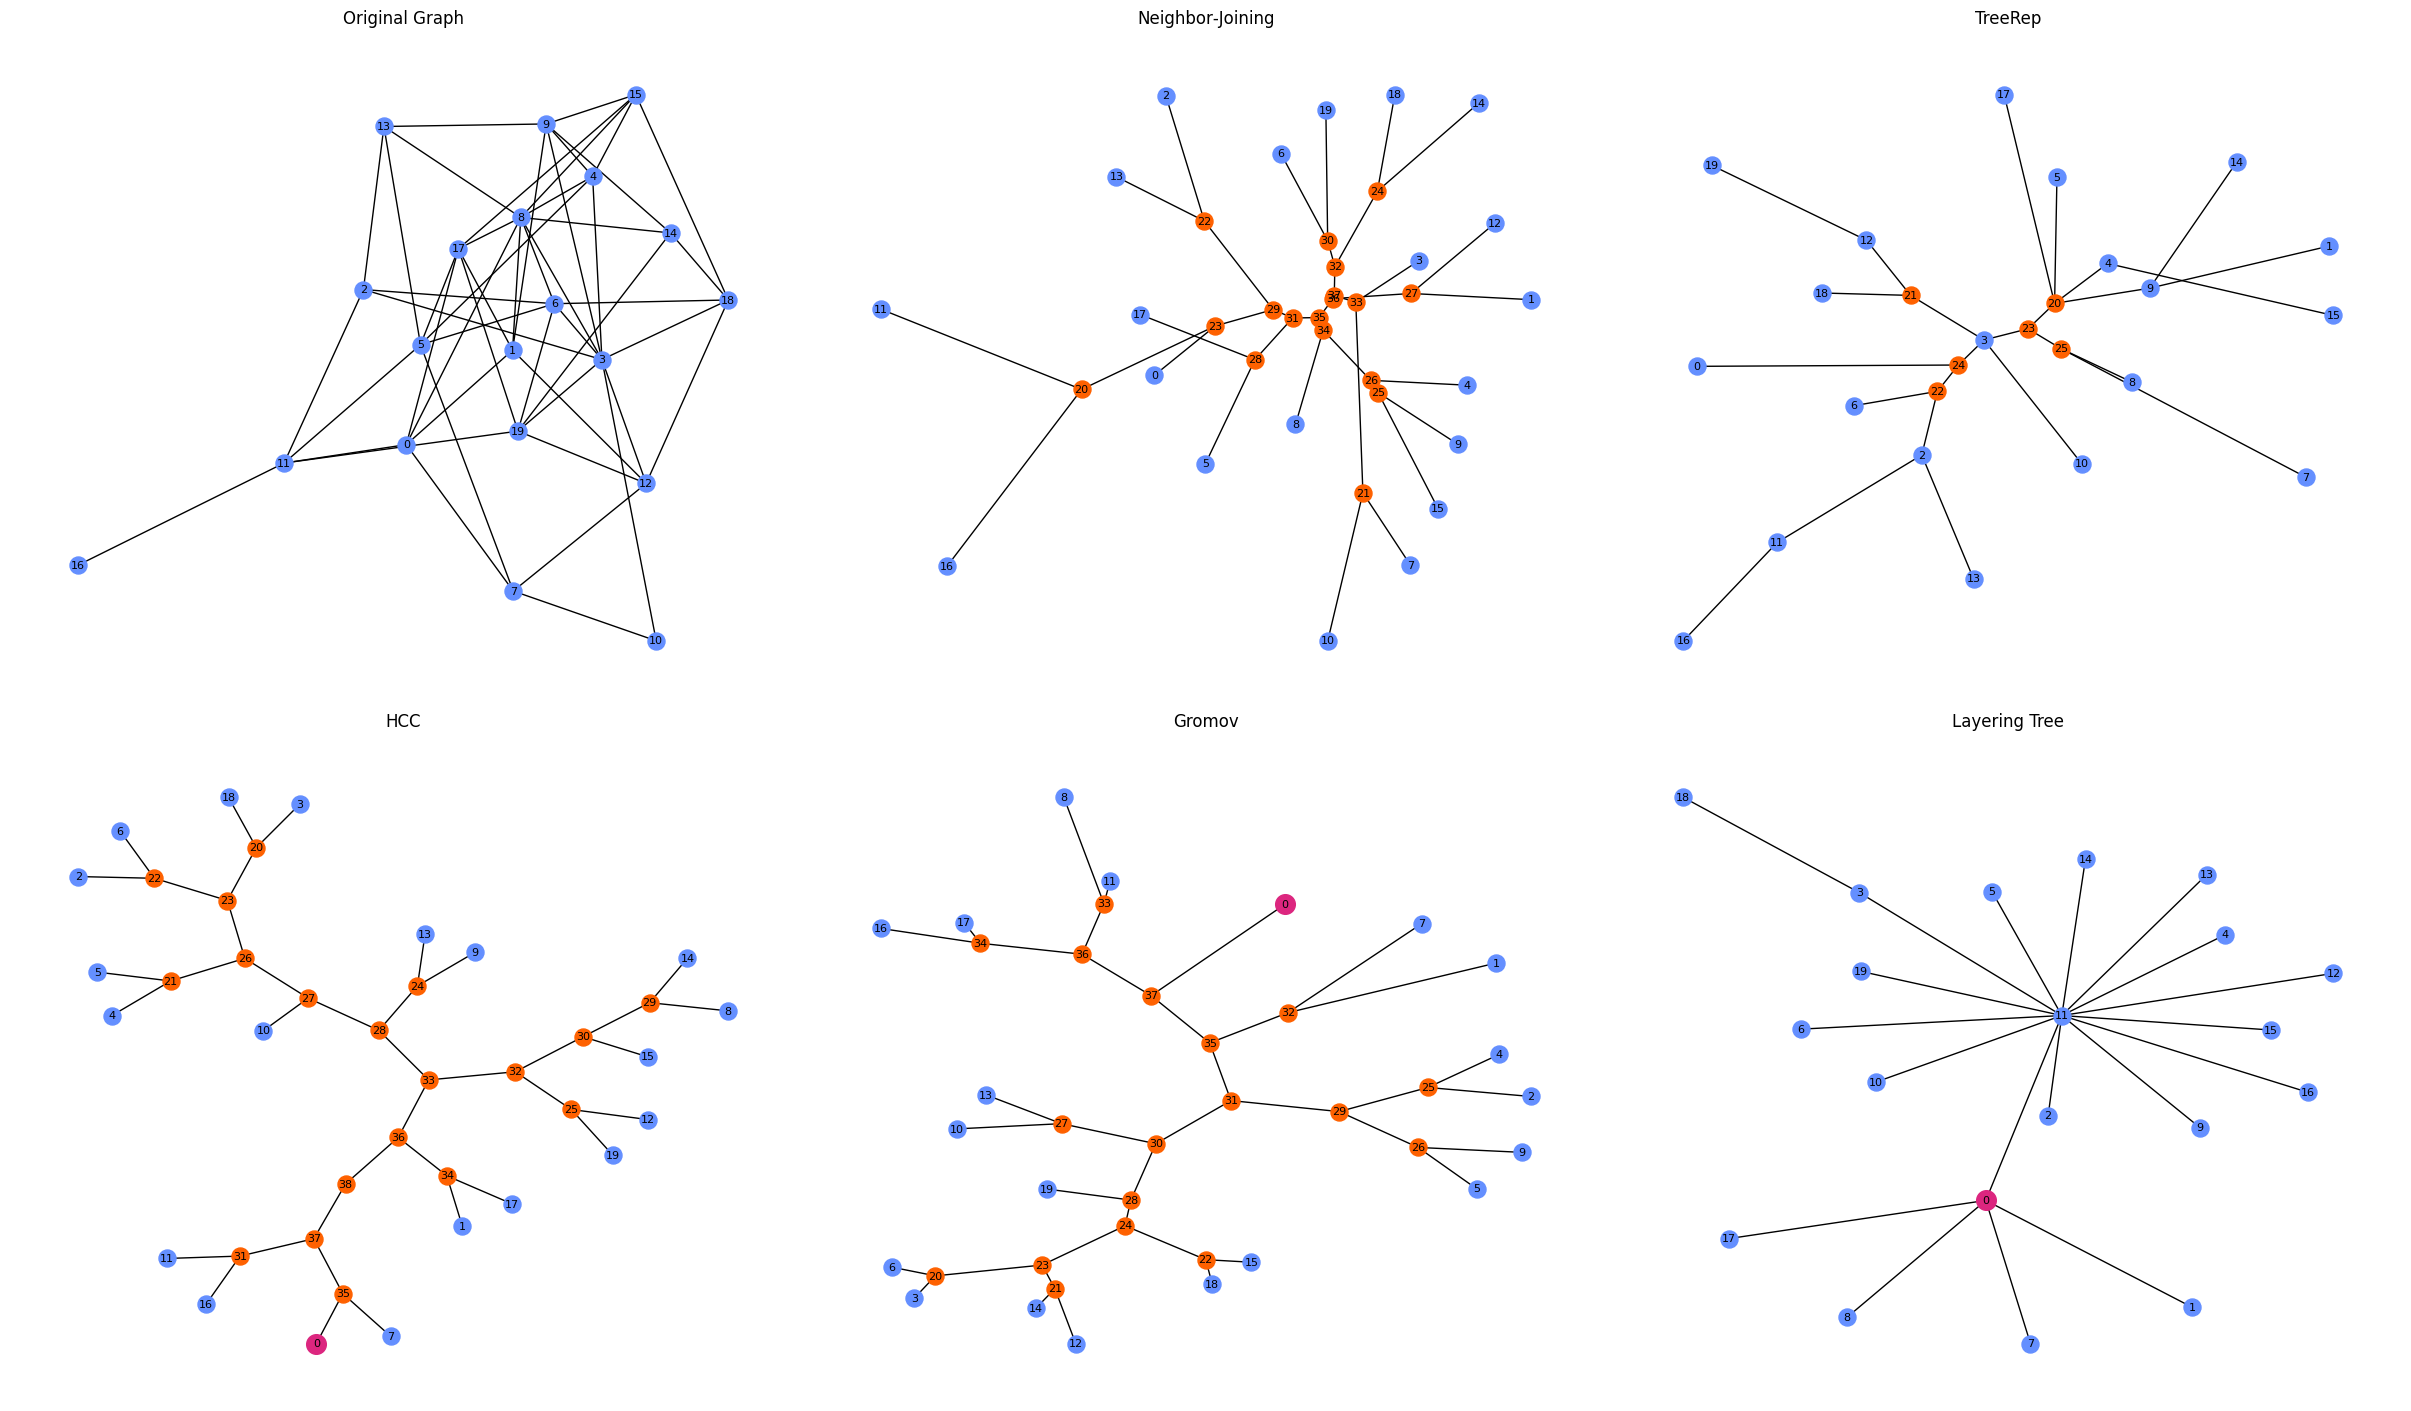

In [62]:
N = 20
root = 0

random_graph = nx.gnp_random_graph(N, 0.3)
distances = nx.floyd_warshall_numpy(random_graph)

tree_nj = NJ(distances)
tree_nj_distances = nx.floyd_warshall_numpy(tree_nj)
for u, v, data in tree_nj.edges(data=True):
        data['len'] = tree_nj_distances[u, v]

tree_TR = TreeRep(distances)
tree_TR.learn_tree()
tree_TR_distances = nx.floyd_warshall_numpy(tree_TR.G)
for u, v, data in tree_TR.G.edges(data=True):
        data['len'] = tree_TR_distances[u, v]

tree_hcc = HccLinkage(distances)
tree_hcc.fit_tree(root)
tree_hcc_distance = nx.floyd_warshall_numpy(tree_hcc.G)
for u, v, data in tree_hcc.G.edges(data=True):
        data['len'] = tree_hcc_distance[u, v]

gromov_distance = gromov_tree(distances, root)
tree_gromov_full = buneman_extraction(gromov_distance, root)
distance_gromov_tree = nx.floyd_warshall_numpy(tree_gromov_full)
for u, v, data in tree_gromov_full.edges(data=True):
        data['len'] = distance_gromov_tree[int(u), int(v)]

layering_tree = layering_approx_tree(random_graph, root)
distance_layering = nx.floyd_warshall(layering_tree)
for u, v, data in layering_tree.edges(data=True):
        data['len'] = distance_layering[u][v]


fig, axes = plt.subplots(2, 3, figsize=(24, 14), constrained_layout=True)
axes = axes.flatten()
# colorblind‑friendly
orig_color = '#648FFF'  # blue
int_color  = '#FE6100'  # orange
root_color = '#DC267F'  # colorblind-friendly green

# 1) Original points with labels
ax = axes[0]
pos = nx.spring_layout(random_graph, seed=0)
nx.draw_networkx_edges(random_graph, pos, ax=ax)
nx.draw_networkx_nodes(random_graph, pos,
                        nodelist=[v for v in random_graph.nodes() if v < N],
                        node_color=orig_color, node_size=150, ax=ax)
nx.draw_networkx_labels(random_graph, pos,
                        labels={v: str(v) for v in random_graph.nodes()},
                        font_size=8, font_color='black', ax=ax)
ax.set_title('Original Graph', pad=10)
ax.axis('off')

# 2) Neighbor‑Joining
ax = axes[1]
pos_nj = graphviz_layout(tree_nj, prog='neato')
orig_nodes_nj = [v for v in tree_nj.nodes() if v < distances.shape[0]]
int_nodes_nj  = [v for v in tree_nj.nodes() if v >= distances.shape[0]]

nx.draw_networkx_edges(tree_nj, pos_nj, ax=ax)
nx.draw_networkx_nodes(tree_nj, pos_nj,
                       nodelist=orig_nodes_nj,
                       node_color=orig_color, node_size=150, ax=ax)
nx.draw_networkx_nodes(tree_nj, pos_nj,
                       nodelist=int_nodes_nj,
                       node_color=int_color,  node_size=150, ax=ax)
nx.draw_networkx_labels(tree_nj, pos_nj,
                        labels={v: str(v) for v in tree_nj.nodes()},
                        font_size=8, font_color='black', ax=ax)

ax.set_title('Neighbor‑Joining', pad=10)
ax.axis('off')

# 3) TreeRep
ax = axes[2]
pos_tr = graphviz_layout(tree_TR.G, prog='neato')
orig_nodes_tr = [v for v in tree_TR.G.nodes() if v < distances.shape[0]]
int_nodes_tr  = [v for v in tree_TR.G.nodes() if v >= distances.shape[0]]

nx.draw_networkx_edges(tree_TR.G, pos_tr, ax=ax)
nx.draw_networkx_nodes(tree_TR.G, pos_tr,
                       nodelist=orig_nodes_tr,
                       node_color=orig_color, node_size=150, ax=ax)
nx.draw_networkx_nodes(tree_TR.G, pos_tr,
                       nodelist=int_nodes_tr,
                       node_color=int_color,  node_size=150, ax=ax)
nx.draw_networkx_labels(tree_TR.G, pos_tr,
                        labels={v: str(v) for v in tree_TR.G.nodes()},
                        font_size=8, font_color='black', ax=ax)

ax.set_title('TreeRep', pad=10)
ax.axis('off')

# 3) HCC
ax = axes[3]
pos_tr = graphviz_layout(tree_hcc.G, prog='neato')
orig_nodes_tr = [v for v in tree_hcc.G.nodes() if v < distances.shape[0]]
int_nodes_tr  = [v for v in tree_hcc.G.nodes() if v >= distances.shape[0]]

nx.draw_networkx_edges(tree_hcc.G, pos_tr, ax=ax)
nx.draw_networkx_nodes(tree_hcc.G, pos_tr,
                       nodelist=orig_nodes_tr,
                       node_color=orig_color, node_size=150, ax=ax)
nx.draw_networkx_nodes(tree_hcc.G, pos_tr,
                       nodelist=int_nodes_tr,
                       node_color=int_color,  node_size=150, ax=ax)
nx.draw_networkx_labels(tree_hcc.G, pos_tr,
                        labels={v: str(v) for v in tree_hcc.G.nodes()},
                        font_size=8, font_color='black', ax=ax)
nx.draw_networkx_nodes(tree_hcc.G, pos_tr,
                       nodelist=[root] if root in tree_hcc.G else [],
                       node_color=root_color, node_size=200, ax=ax)

ax.set_title('HCC', pad=10)
ax.axis('off')

# 4) Gromov
ax = axes[4]
pos_tr = graphviz_layout(tree_gromov_full, prog='neato')
orig_nodes_tr = [v for v in tree_gromov_full.nodes() if v < distances.shape[0]]
int_nodes_tr  = [v for v in tree_gromov_full.nodes() if v >= distances.shape[0]]
nx.draw_networkx_edges(tree_gromov_full, pos_tr, ax=ax)
nx.draw_networkx_nodes(tree_gromov_full, pos_tr,
                       nodelist=orig_nodes_tr,
                       node_color=orig_color, node_size=150, ax=ax)
nx.draw_networkx_nodes(tree_gromov_full, pos_tr,
                       nodelist=int_nodes_tr,
                       node_color=int_color,  node_size=150, ax=ax)
nx.draw_networkx_labels(tree_gromov_full, pos_tr,
                        labels={v: str(v) for v in tree_gromov_full.nodes()},
                        font_size=8, font_color='black', ax=ax)
nx.draw_networkx_nodes(tree_gromov_full, pos_tr,
                       nodelist=[root] if root in tree_gromov_full else [],
                       node_color=root_color, node_size=200, ax=ax)


ax.set_title('Gromov', pad=10)
ax.axis('off')

# 5) Chepoi
ax = axes[5]
pos_tr = graphviz_layout(layering_tree, prog='neato')
orig_nodes_tr = [v for v in layering_tree.nodes() if v < distances.shape[0]]
int_nodes_tr  = [v for v in layering_tree.nodes() if v >= distances.shape[0]]
nx.draw_networkx_edges(layering_tree, pos_tr, ax=ax)
nx.draw_networkx_nodes(layering_tree, pos_tr,
                       nodelist=orig_nodes_tr,
                       node_color=orig_color, node_size=150, ax=ax)
nx.draw_networkx_nodes(layering_tree, pos_tr,
                       nodelist=int_nodes_tr,
                       node_color=int_color,  node_size=150, ax=ax)
nx.draw_networkx_labels(layering_tree, pos_tr,
                        labels={v: str(v) for v in layering_tree.nodes()},
                        font_size=8, font_color='black', ax=ax)
nx.draw_networkx_nodes(layering_tree, pos_tr,
                       nodelist=[root] if root in layering_tree else [],
                       node_color=root_color, node_size=200, ax=ax)


ax.set_title('Layering Tree', pad=10)
ax.axis('off')

plt.show()

In [63]:
N = 20
root = 0

random_graph = nx.gnp_random_graph(N, 0.3)
distances = nx.floyd_warshall_numpy(random_graph)

gromov_distance = gromov_tree(distances, root)
tree_gromov_full = buneman_extraction(gromov_distance, root)
""" distance_gromov_tree = nx.floyd_warshall_numpy(tree_gromov_full)
for u, v, data in tree_gromov_full.edges(data=True):
        data['len'] = distance_gromov_tree[int(u), int(v)] """

" distance_gromov_tree = nx.floyd_warshall_numpy(tree_gromov_full)\nfor u, v, data in tree_gromov_full.edges(data=True):\n        data['len'] = distance_gromov_tree[int(u), int(v)] "

In [64]:
nx.shortest_path_length(random_graph)

<generator object all_pairs_shortest_path_length at 0x7fd44650c440>

In [65]:
pairwise_distances = nx.floyd_warshall_numpy(random_graph)

In [66]:
pairwise_distances

array([[0., 2., 2., 1., 1., 2., 3., 2., 2., 2., 3., 1., 2., 2., 3., 1.,
        2., 2., 2., 2.],
       [2., 0., 2., 1., 1., 2., 2., 2., 2., 2., 3., 2., 2., 2., 1., 1.,
        1., 2., 2., 2.],
       [2., 2., 0., 2., 1., 2., 2., 2., 2., 2., 1., 2., 1., 2., 3., 2.,
        2., 2., 1., 1.],
       [1., 1., 2., 0., 1., 2., 2., 2., 1., 1., 2., 1., 2., 1., 2., 2.,
        2., 1., 2., 2.],
       [1., 1., 1., 1., 0., 1., 2., 1., 2., 2., 2., 2., 1., 1., 2., 2.,
        1., 1., 2., 1.],
       [2., 2., 2., 2., 1., 0., 2., 2., 2., 1., 3., 2., 2., 2., 1., 3.,
        2., 2., 3., 2.],
       [3., 2., 2., 2., 2., 2., 0., 2., 2., 3., 1., 2., 2., 2., 1., 2.,
        2., 1., 2., 2.],
       [2., 2., 2., 2., 1., 2., 2., 0., 1., 1., 1., 2., 1., 2., 3., 2.,
        2., 1., 1., 2.],
       [2., 2., 2., 1., 2., 2., 2., 1., 0., 1., 1., 2., 2., 2., 3., 1.,
        2., 1., 2., 2.],
       [2., 2., 2., 1., 2., 1., 3., 1., 1., 0., 2., 1., 2., 1., 2., 2.,
        3., 2., 2., 1.],
       [3., 3., 1., 2., 2., 3.

In [67]:
nx.floyd_warshall_numpy(tree_gromov_full)[-1,:]

array([2.5, 3. , 3. , 2.5, 3. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. ,
       2. , 2. , 2. , 2. , 2. , 2. , 2. , 2. , 1.5, 2. , 2. , 1.5, 2. ,
       2. , 1.5, 1.5, 1. , 1. , 1. , 1. , 1. , 1. , 1. , 1. , 0. ])

In [68]:
l = np.argsort(tree_gromov_full.nodes)

In [69]:
#nx.floyd_warshall_numpy(tree_gromov_full)[l][0,l]

In [70]:
distances[0,:20]

array([0., 2., 2., 1., 1., 2., 3., 2., 2., 2., 3., 1., 2., 2., 3., 1., 2.,
       2., 2., 2.])

In [71]:
nx.floyd_warshall_numpy(tree_gromov_full)[l][0,l[:20]]

array([0., 2., 2., 1., 1., 2., 3., 2., 2., 2., 3., 1., 2., 2., 3., 1., 2.,
       2., 2., 2.])

In [72]:
nx.floyd_warshall_numpy(tree_gromov_full)[l][:20,l[:20]]

array([[0., 2., 2., 1., 1., 2., 3., 2., 2., 2., 3., 1., 2., 2., 3., 1.,
        2., 2., 2., 2.],
       [2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 0.],
       [2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 0.],
       [1., 1., 1., 0., 0., 1., 2., 1., 1., 1., 2., 0., 1., 1., 2., 0.,
        1., 1., 1., 1.],
       [1., 1., 1., 0., 0., 1., 2., 1., 1., 1., 2., 0., 1., 1., 2., 0.,
        1., 1., 1., 1.],
       [2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 0.],
       [3., 1., 1., 2., 2., 1., 0., 1., 1., 2., 1., 2., 2., 1., 1., 2.,
        2., 1., 2., 1.],
       [2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 0.],
       [2., 0., 0., 1., 1., 0., 1., 0., 0., 1., 1., 1., 1., 0., 1., 1.,
        1., 0., 1., 0.],
       [2., 1., 1., 1., 1., 1., 2., 1., 1., 0., 2., 1., 1., 1., 2., 1.,
        1., 1., 1., 1.],
       [3., 1., 1., 2., 2., 1.